Best K0 = 26.282
RMS fractional mismatch (acoustic) = 0.260


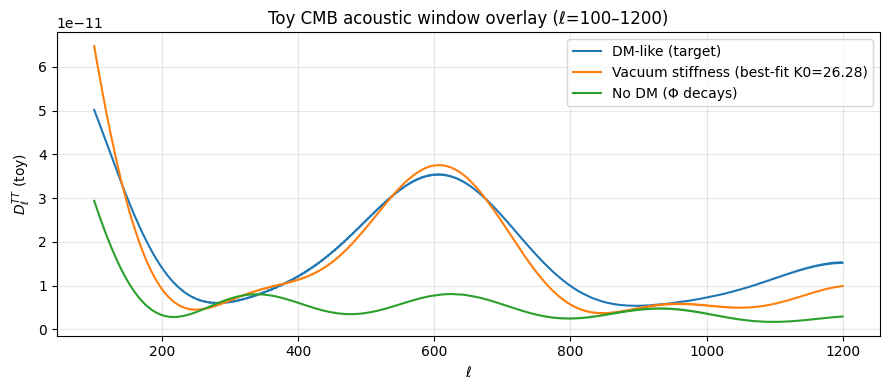

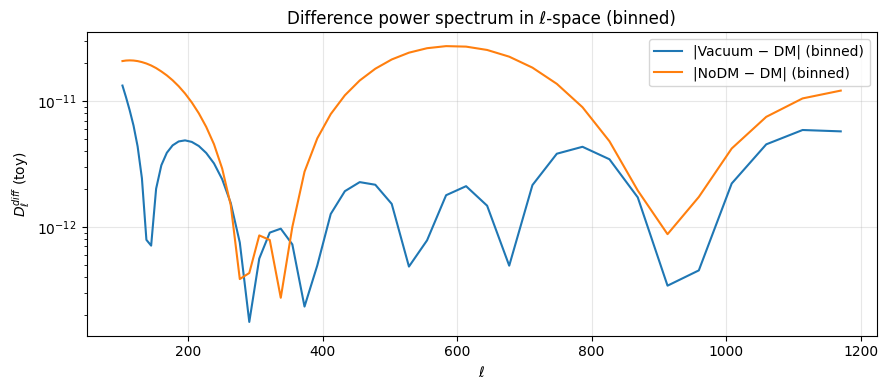

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn

# === TEST_A  ===

# ----------------------------
# Geometry
# ----------------------------
D_star = 14_000.0   # comoving distance to last scattering [Mpc]
r_s    = 144.0      # sound horizon [Mpc]
k_D    = 0.14       # Silk damping scale [1/Mpc]

# ----------------------------
# Primordial spectrum
# ----------------------------
A_s = 2.1e-9
n_s = 0.965
k0  = 0.05

def P_prim(k):
    return A_s * (k / k0)**(n_s - 1.0)

Phi0 = 1.0

def Phi_DM_like(k):
    return Phi0 * np.ones_like(k)

def Phi_noDM(k, k_eq=0.01, alpha=2.0):
    return Phi0 / (1.0 + (k / k_eq)**alpha)

def Phi_vacuum_stiffness(k, K0=10.0, k_s=0.03, p=4, k_eq=0.01, alpha=2.0):
    Kk = K0 * (k**p) / (k**p + k_s**p)
    return Phi0 * (1.0 + Kk) / (1.0 + Kk + (k / k_eq)**alpha)

def Theta_toy(k, Phi_k, Ab=0.25, Bb=0.18, drive0=0.35, eps=0.05, k_ref=0.05):
    acoustic = Ab * np.cos(k * r_s) + Bb * np.sin(k * r_s)
    drive    = drive0 * (1.0 + eps * np.log(k / k_ref)) * Phi_k
    damping  = np.exp(-(k / k_D)**2)
    return (acoustic + drive) * damping

def Cl_TT_toy(ells, Phi_func, Nk=3500):
    k = np.logspace(-4, np.log10(0.5), Nk)
    dlnk = np.log(k[1] / k[0])

    Phi_k = Phi_func(k)
    Theta = Theta_toy(k, Phi_k)

    pref = P_prim(k) * Theta**2
    x = k * D_star

    cls = np.zeros(len(ells))
    for i, ell in enumerate(ells):
        jl = spherical_jn(ell, x)
        cls[i] = np.sum(pref * jl**2) * dlnk

    return ells * (ells + 1) * cls / (2 * np.pi)

# ----------------------------
# Setup ℓ range and acoustic mask
# ----------------------------
ells = np.arange(2, 2000)
ELL_MIN, ELL_MAX = 100, 1200
mask = (ells >= ELL_MIN) & (ells <= ELL_MAX)

# Compute reference spectra
D_DM   = Cl_TT_toy(ells, Phi_DM_like)
D_noDM = Cl_TT_toy(ells, Phi_noDM)

def fit_amp(D_target, D_model, mask):
    num = np.dot(D_target[mask], D_model[mask])
    den = np.dot(D_model[mask], D_model[mask])
    return num / den if den > 0 else 1.0

# ----------------------------
# Scan K0 to match TT in acoustic window
# ----------------------------
K0_grid = np.linspace(25, 35, 40)
scores = []

for K0 in K0_grid:
    Dv = Cl_TT_toy(ells, lambda k, K0=K0: Phi_vacuum_stiffness(k, K0=K0))
    a  = fit_amp(D_DM, Dv, mask)
    frac = np.sqrt(np.mean(((D_DM[mask] - a * Dv[mask]) / D_DM[mask])**2))
    scores.append(frac)

scores = np.array(scores)
best_K0 = K0_grid[np.argmin(scores)]

print(f"Best K0 = {best_K0:.3f}")
print(f"RMS fractional mismatch (acoustic) = {scores.min():.3f}")

# Best-fit vacuum curve
D_vac0 = Cl_TT_toy(ells, lambda k: Phi_vacuum_stiffness(k, K0=best_K0))
a_best = fit_amp(D_DM, D_vac0, mask)
D_vac  = a_best * D_vac0

# ----------------------------
# Figure 1: TT overlay
# ----------------------------
plt.figure(figsize=(9,4))
plt.plot(ells[mask], D_DM[mask],   label="DM-like (target)")
plt.plot(ells[mask], D_vac[mask],  label=f"Vacuum stiffness (best-fit K0={best_K0:.2f})")
plt.plot(ells[mask], D_noDM[mask], label="No DM (Φ decays)")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{TT}$ (toy)")
plt.title(f"Toy CMB acoustic window overlay (ℓ={ELL_MIN}–{ELL_MAX})")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Figure 2 diagnostic: binned difference spectra in ℓ-space
# ----------------------------
Ddiff_v = np.abs(D_vac  - D_DM)
Ddiff_n = np.abs(D_noDM - D_DM)

def logbin_ell(ell, y, ell_min, ell_max, nbins=50):
    m = (ell >= ell_min) & (ell <= ell_max)
    ell = ell[m]
    y   = y[m]
    bins = np.logspace(np.log10(ell_min), np.log10(ell_max), nbins + 1)
    ell_c = np.sqrt(bins[:-1] * bins[1:])
    yb = np.full(nbins, np.nan)
    for i in range(nbins):
        sel = (ell >= bins[i]) & (ell < bins[i+1])
        if np.any(sel):
            yb[i] = np.mean(y[sel])
    return ell_c, yb

ellc, Ddiff_v_b = logbin_ell(ells, Ddiff_v, ELL_MIN, ELL_MAX, nbins=50)
_,    Ddiff_n_b = logbin_ell(ells, Ddiff_n, ELL_MIN, ELL_MAX, nbins=50)

plt.figure(figsize=(9,4))
plt.semilogy(ellc, Ddiff_v_b + 1e-30, label="|Vacuum − DM| (binned)")
plt.semilogy(ellc, Ddiff_n_b + 1e-30, label="|NoDM − DM| (binned)")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{diff}$ (toy)")
plt.title("Difference power spectrum in ℓ-space (binned)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()



TEST B (toy, ℓ-space): EE + TE phase test for DM vs Vacuum stiffness vs No-DM ===

Best-fit K0 from Test A = 26.28


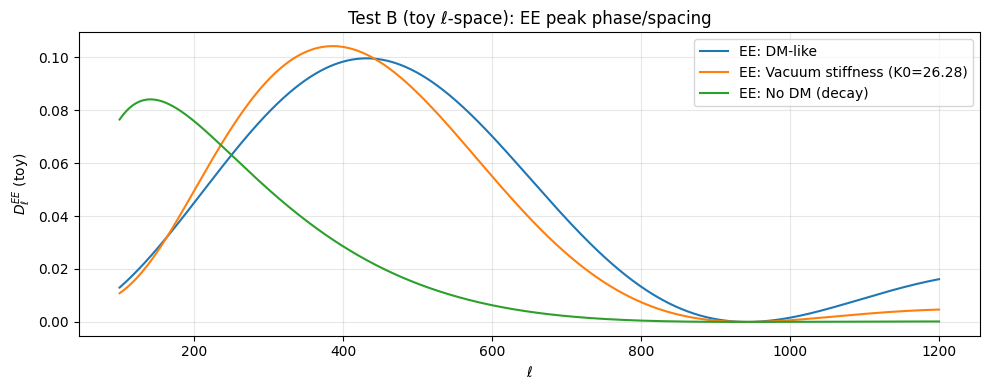

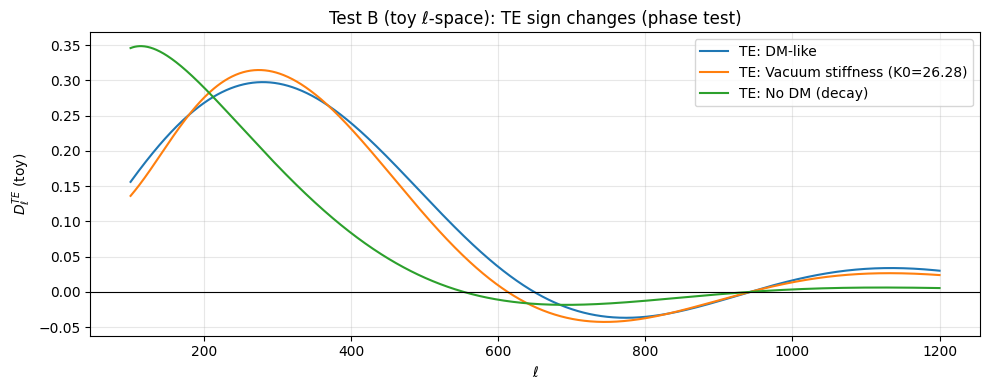

=== Test B metrics (acoustic window) ===
EE: vacuum vs DM frac-RMS = 0.396
EE: noDM  vs DM frac-RMS  = 1.136
TE: vacuum vs DM rel-RMS  = 0.093
TE: noDM  vs DM rel-RMS   = 0.523


In [2]:
# === Test B (toy, ℓ-space): EE + TE phase test for DM vs Vacuum stiffness vs No-DM ===
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# User knobs
# -------------------------------------------------------
ELL_MIN, ELL_MAX = 2, 2000
ELL_WIN_MIN, ELL_WIN_MAX = 100, 1200   # your acoustic window preference
ells = np.arange(ELL_MIN, ELL_MAX+1)

# Acoustic scale (sets peak spacing). Tune once; doesn't affect the logic.
ell_A = 300.0

# Damping envelope (toy Silk tail)
ell_D = 1400.0

# -------------------------------------------------------
# "Stabilization / potential response" factors in ℓ-space
# (This is where DM / NoDM / Vacuum differ in this toy test.)
# -------------------------------------------------------
def S_DM(ell):
    return np.ones_like(ell, dtype=float)

def S_noDM(ell, ell_eq=120.0, alpha=1.6):
    # decays: mimics potential decay -> suppressed driving/velocity
    return 1.0 / (1.0 + (ell/ell_eq)**alpha)

def S_vac(ell, K0=10.0, ell_s=250.0, p=4, ell_eq=120.0, alpha=1.6):
    # saturating stiffness response
    K = K0 * (ell**p)/(ell**p + ell_s**p)
    return (1.0 + K)/(1.0 + K + (ell/ell_eq)**alpha)

# -------------------------------------------------------
# Toy source decomposition: density ~ cos, velocity ~ sin
# TT mixes them + driving; EE from velocity; TE cross
# -------------------------------------------------------
def env(ell):
    return np.exp(-(ell/ell_D)**2)

def TT_toy(ell, S, Ad=1.0, Av=0.25, drive=0.35):
    # density (cos), velocity (sin), plus a driving term proportional to S(ell)
    phase = ell/ell_A
    dens = Ad*np.cos(phase)
    vel  = Av*np.sin(phase)
    return env(ell) * (dens + vel + drive*S)

def EE_toy(ell, S, Ev=0.35):
    # polarization ~ velocity * S(ell) (since velocity sourcing depends on stabilization)
    phase = ell/ell_A
    vel = Ev*np.sin(phase)
    return env(ell) * (S * vel)

# Power spectra (toy): square / product of sources
def D_TT(ell, S): return (TT_toy(ell, S)**2)
def D_EE(ell, S): return (EE_toy(ell, S)**2)
def D_TE(ell, S): return (TT_toy(ell, S) * EE_toy(ell, S))



print(f"Best-fit K0 from Test A = {best_K0:.2f}")


# -------------------------------------------------------
# Build three cases
# -------------------------------------------------------

DTT_DM   = D_TT(ells, S_DM(ells))
DEE_DM   = D_EE(ells, S_DM(ells))
DTE_DM   = D_TE(ells, S_DM(ells))

DTT_no   = D_TT(ells, S_noDM(ells))
DEE_no   = D_EE(ells, S_noDM(ells))
DTE_no   = D_TE(ells, S_noDM(ells))

DTT_vac  = D_TT(ells, S_vac(ells, K0=best_K0))
DEE_vac  = D_EE(ells, S_vac(ells, K0=best_K0))
DTE_vac  = D_TE(ells, S_vac(ells, K0=best_K0))

# -------------------------------------------------------
# Fit amplitude in acoustic window for shape/phase comparison
# -------------------------------------------------------
mask = (ells >= ELL_WIN_MIN) & (ells <= ELL_WIN_MAX)

def fit_amp(target, model):
    return np.dot(target[mask], model[mask])/(np.dot(model[mask], model[mask]) + 1e-30)

aEE_v = fit_amp(DEE_DM, DEE_vac)
aEE_n = fit_amp(DEE_DM, DEE_no)

aTE_v = fit_amp(DTE_DM, DTE_vac)
aTE_n = fit_amp(DTE_DM, DTE_no)

# -------------------------------------------------------
# Plots
# -------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(ells[mask], DEE_DM[mask], label="EE: DM-like")
plt.plot(ells[mask], (aEE_v*DEE_vac)[mask], label=f"EE: Vacuum stiffness (K0={best_K0:.2f})")
plt.plot(ells[mask], (aEE_n*DEE_no)[mask], label="EE: No DM (decay)")
plt.title("Test B (toy ℓ-space): EE peak phase/spacing")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{EE}$ (toy)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(ells[mask], DTE_DM[mask], label="TE: DM-like")
plt.plot(ells[mask], (aTE_v*DTE_vac)[mask], label=f"TE: Vacuum stiffness (K0={best_K0:.2f})")
plt.plot(ells[mask], (aTE_n*DTE_no)[mask], label="TE: No DM (decay)")
plt.axhline(0, color='k', lw=0.8)
plt.title("Test B (toy ℓ-space): TE sign changes (phase test)")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{TE}$ (toy)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Simple metrics
# -------------------------------------------------------
def frac_rms(target, model):
    return np.sqrt(np.mean(((target[mask]-model[mask]) / np.maximum(np.abs(target[mask]), 1e-30))**2))

# For TE (crosses zero), use RMS absolute normalized by target RMS
def rel_rms_TE(target, model):
    return np.sqrt(np.mean((target[mask]-model[mask])**2)) / (np.sqrt(np.mean(target[mask]**2)) + 1e-30)

print("=== Test B metrics (acoustic window) ===")
print(f"EE: vacuum vs DM frac-RMS = {frac_rms(DEE_DM, aEE_v*DEE_vac):.3f}")
print(f"EE: noDM  vs DM frac-RMS  = {frac_rms(DEE_DM, aEE_n*DEE_no):.3f}")
print(f"TE: vacuum vs DM rel-RMS  = {rel_rms_TE(DTE_DM, aTE_v*DTE_vac):.3f}")
print(f"TE: noDM  vs DM rel-RMS   = {rel_rms_TE(DTE_DM, aTE_n*DTE_no):.3f}")



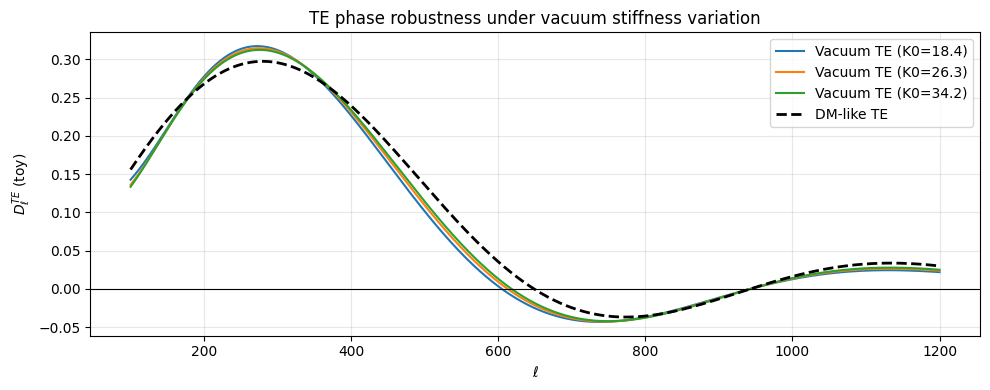

In [3]:
# === Robustness test: K0 sweep (NO refitting) ===
K0_center = best_K0           # TT-optimized value
K0_vals = [0.7*K0_center, K0_center, 1.3*K0_center]

plt.figure(figsize=(10,4))

for K0 in K0_vals:
    S = S_vac(ells, K0=K0)
    DTE = D_TE(ells, S)

    # scale once using DM reference (same as before)
    a = fit_amp(DTE_DM, DTE)
    plt.plot(
        ells[mask],
        (a*DTE)[mask],
        label=f"Vacuum TE (K0={K0:.1f})"
    )

plt.plot(ells[mask], DTE_DM[mask], 'k--', lw=2, label="DM-like TE")
plt.axhline(0, color='k', lw=0.8)

plt.title("TE phase robustness under vacuum stiffness variation")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell^{TE}$ (toy)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()